# GSPLAT training & rasterization investigation

In [4]:
import os
os.chdir("/home/minhtran/Code/gsplat/examples")

In [14]:
from datasets.colmap import Parser
from datasets.colmap_rgba import DatasetRGBA

## DataLoader

In [30]:
import imageio.v2 as imageio

In [15]:
FRAME = "00000000"

In [16]:
data_dir = f"/home/minhtran/Code/data/vocap/minh_2/frames/{FRAME}/train/rgba"
data_factor = 1
normalize = False
test_every = 6
result_dir = f"/home/minhtran/Code/data/vocap/minh_2/gsplat_results/frames/{FRAME}/train/rgba"

In [17]:
parser = Parser(
    data_dir=data_dir,
    factor=data_factor,
    normalize=normalize,
    test_every=test_every,
)

[Parser] 49 images, taken by 49 cameras.


In [32]:
index = 0
img = imageio.imread(parser.image_paths[index])

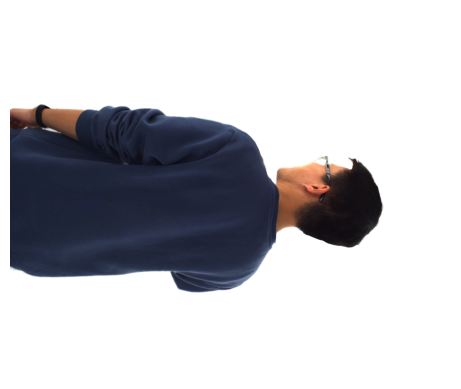

In [33]:
# Display img
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()

In [37]:
alphas = img[..., 3]

In [39]:
alphas.max()

255

In [ ]:
# Apply alpha channel to RGB image
rgb_img = img[..., :3]
rgb_img = rgb_img * (alphas[..., None] / 255.0) + 

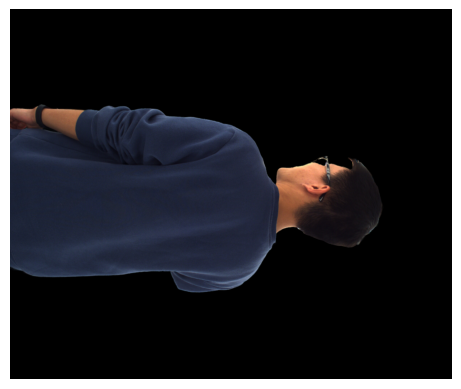

In [41]:
# Display rgb_img
plt.imshow(rgb_img.astype('uint8'))
plt.axis('off')
plt.show()